# Industrial Audio - Classification Model
#### Illustrated with LAX Airplane Landing - Binary Classifier 
Last Updated October 14, 2019

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import pywt
from matplotlib.image import imread
import numpy as np
import os
from scipy.io import wavfile
from pathlib import Path
import pywt
import soundfile
import random
import pickle
from glob import iglob
import crepe
from sklearn.metrics import confusion_matrix, classification_report
import pprint
import seaborn as sns
random.seed(42)
import librosa
import scipy.signal
from keras.layers import MaxPooling2D, Flatten, Conv2D
from keras.utils import to_categorical
import keras
from keras.layers import initializers 
from keras.layers import regularizers 
from keras.layers import constraints 
from keras.layers import Activation
from keras.layers.advanced_activations import PReLU
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.advanced_activations import ELU
from keras.constraints import max_norm
from keras.layers import LeakyReLU
from keras import optimizers, losses, activations, models
from keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
from keras.layers import Dense, Input, Dropout, Convolution1D, MaxPool1D, GlobalMaxPool1D, GlobalAveragePooling1D, \
    concatenate
from keras.layers import MaxPooling3D, Flatten, Conv3D
from keras import backend as K
from keras.layers import LeakyReLU,PReLU
import keras
from keras.losses import *
def my_init(shape,  dtype=None):
    vals=((float(shape[0], float(shape[1]))) * math.sqrt(2./float(shape[1])))
    return K.random_normal(vals, dtype=dtype)    
import math
from pydub import AudioSegment
from pydub.playback import play

import tkinter
from matplotlib.backends.backend_tkagg import (
    FigureCanvasTkAgg, NavigationToolbar2Tk)
# Implement the default Matplotlib key bindings.
from matplotlib.backend_bases import key_press_handler
from matplotlib.figure import Figure
import nlpaug
import nlpaug.augmenter.spectrogram as nas
import nlpaug.flow 
import nlpaug.flow as naf

from nlpaug.util.file.load import LoadUtil
from nlpaug.util.visual.spectrogram import VisualSpectrogram

Using TensorFlow backend.
C:\Anaconda\envs\amlrealtimeai\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Anaconda\envs\amlrealtimeai\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Anaconda\envs\amlrealtimeai\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Anaconda\envs\amlrealtimeai\lib\site-packages\tensorflow\py

In [2]:
# os.chdir("D:\\aircraft-audio\lax-naming-convention")
# import IPython
# from IPython.display import Image, Audio
# print("Embraer")
# Image(filename='embardier.png',width=300, height=200)

### Load and Inspect Data

In [3]:
# Original audio recordings have already been split to samples of 1 second 32000 at sample rate and stored in numpy array.

os.chdir("D:\\aircraft-audio\\local-data")
print(os.getcwd())

Boeing_slices_train_matrix = np.loadtxt('Boeing_slices_train_matrix.txt', delimiter=',')
Boeing_slices_test_matrix = np.loadtxt('Boeing_slices_test_matrix.txt', delimiter=',')
Embraer_slices_train_matrix = np.loadtxt('Embraer_slices_train_matrix.txt', delimiter=',')
Embraer_slices_test_matrix = np.loadtxt('Embraer_slices_test_matrix.txt', delimiter=',')
Bombardier_slices_train_matrix = np.loadtxt('Bombardier_slices_train_matrix.txt', delimiter=',')
Bombardier_slices_test_matrix = np.loadtxt('Bombardier_slices_test_matrix.txt', delimiter=',')
Airbus_slices_train_matrix = np.loadtxt('Airbus_slices_train_matrix.txt', delimiter=',')
Airbus_slices_test_matrix = np.loadtxt('Airbus_slices_test_matrix.txt', delimiter=',')


D:\aircraft-audio\local-data


C:\Users\pattyry\AppData\Roaming\Python\Python36\site-packages\scipy\sparse\lil.py:514: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not j.flags.writeable or j.dtype not in (np.int32, np.int64):


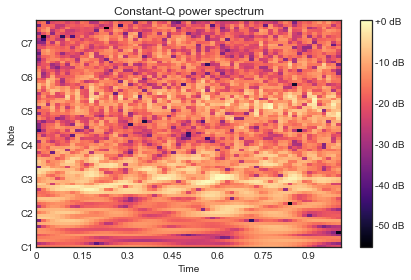

In [4]:
import librosa.display
import matplotlib.pyplot as plt
C = np.abs(librosa.cqt(Boeing_slices_train_matrix[20,:], sr=32000, fmin=librosa.note_to_hz('C1'), n_bins=80, bins_per_octave=12))
librosa.display.specshow(librosa.amplitude_to_db(C, ref=np.max),
                         sr=32000, x_axis='time', y_axis='cqt_note')
plt.colorbar(format='%+2.0f dB')
plt.title('Constant-Q power spectrum')
plt.tight_layout()

[-4501. -4725. -3986. ... -1628. -1210. -1030.]


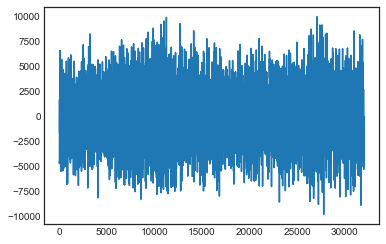

In [5]:
signal = Boeing_slices_train_matrix[40,:]
time = 32000
print(signal)
plt.plot(signal)
plt.show()

### Add Augmented Data

In [6]:
def _create_augmented_volume_reduction_data_matrix(old_matrix, volume_change):
    
    old_matrix = np.asarray(old_matrix)
    new_target_numpy = np.empty((32000),int)
    new_target_numpy = np.asarray(new_target_numpy)    

    for i in range(old_matrix.shape[0]):
        new_numpy = old_matrix[i,:] + volume_change
        new_numpy = np.asarray(new_numpy)
        new_target_numpy = np.vstack((new_target_numpy, new_numpy))
        new_target_numpy = np.asarray(new_target_numpy)
    return(new_target_numpy)

In [7]:
# Create Augmented matrices with volume reduction
Boeing_augmented_train_matrix= _create_augmented_volume_reduction_data_matrix(Boeing_slices_train_matrix, -5)
Embraer_augmented_train_matrix= _create_augmented_volume_reduction_data_matrix(Embraer_slices_train_matrix, -5)
Bombardier_augmented_train_matrix= _create_augmented_volume_reduction_data_matrix(Bombardier_slices_train_matrix, -5)
Airbus_augmented_train_matrix= _create_augmented_volume_reduction_data_matrix(Airbus_slices_train_matrix, -5)


In [8]:
Embraer_augmented_train_matrix4 = _create_augmented_volume_reduction_data_matrix(Embraer_slices_train_matrix, -7)

In [9]:
def _create_augmented_white_noise_data_matrix(old_matrix, noise_level):
    new_target_numpy = np.empty((32000),int)
    new_target_numpy = np.asarray(new_target_numpy)   
    
    for i in range(old_matrix.shape[0]):
        wn = np.random.randn(old_matrix.shape[1])
        new_numpy = old_matrix[i,:] + noise_level*wn
        new_numpy = np.asarray(new_numpy)
        new_target_numpy = np.vstack((new_target_numpy, new_numpy))
        new_target_numpy = np.asarray(new_target_numpy)
    return(new_target_numpy)
        

In [10]:
# Create Augmented matrices with white noise added
Embraer_augmented_train_matrix2= _create_augmented_white_noise_data_matrix(Embraer_slices_train_matrix,0.01)
Boeing_augmented_train_matrix2= _create_augmented_white_noise_data_matrix(Boeing_slices_train_matrix,0.01)
Bombardier_augmented_train_matrix2= _create_augmented_white_noise_data_matrix(Bombardier_slices_train_matrix,0.01)
Airbus_augmented_train_matrix2= _create_augmented_white_noise_data_matrix(Airbus_slices_train_matrix,0.01)


In [11]:
# Create Augmented matrices with white noise added
Embraer_augmented_train_matrix3 = _create_augmented_white_noise_data_matrix(Embraer_slices_train_matrix,0.09)
Boeing_augmented_train_matrix3 = _create_augmented_white_noise_data_matrix(Boeing_slices_train_matrix,0.09)
Bombardier_augmented_train_matrix3 = _create_augmented_white_noise_data_matrix(Bombardier_slices_train_matrix,0.09)
Airbus_augmented_train_matrix3 = _create_augmented_white_noise_data_matrix(Airbus_slices_train_matrix,0.09)

In [12]:
# Create Augmented matrices with white noise added
Embraer_augmented_train_matrix4 = _create_augmented_white_noise_data_matrix(Embraer_slices_train_matrix,0.01)

### Add Labels

In [13]:
#Source Data Matrices

Boeing_slices_train_matrix = np.c_[ np.ones(len(Boeing_slices_train_matrix)),Boeing_slices_train_matrix] 
Boeing_slices_train_matrix[:, 0] =  0
print(Boeing_slices_train_matrix.shape)

Boeing_slices_test_matrix = np.c_[ np.ones(len(Boeing_slices_test_matrix)),Boeing_slices_test_matrix] 
Boeing_slices_test_matrix[:, 0] =  0
print(Boeing_slices_test_matrix.shape)

Embraer_slices_train_matrix = np.c_[ np.ones(len(Embraer_slices_train_matrix)),Embraer_slices_train_matrix] 
Embraer_slices_train_matrix[:, 0] = 1
print(Embraer_slices_train_matrix.shape)

Embraer_slices_test_matrix = np.c_[ np.ones(len(Embraer_slices_test_matrix)),Embraer_slices_test_matrix] 
Embraer_slices_test_matrix[:, 0] =  1
print(Embraer_slices_test_matrix.shape)

Bombardier_slices_train_matrix = np.c_[ np.ones(len(Bombardier_slices_train_matrix)),Bombardier_slices_train_matrix] 
Bombardier_slices_train_matrix[:, 0] = 0
print(Bombardier_slices_train_matrix.shape)

Bombardier_slices_test_matrix = np.c_[ np.ones(len(Bombardier_slices_test_matrix)),Bombardier_slices_test_matrix] 
Bombardier_slices_test_matrix[:, 0] =  0
print(Bombardier_slices_test_matrix.shape)

Airbus_slices_train_matrix = np.c_[ np.ones(len(Airbus_slices_train_matrix)),Airbus_slices_train_matrix] 
Airbus_slices_train_matrix[:, 0] = 0
print(Embraer_slices_train_matrix.shape)

Airbus_slices_test_matrix = np.c_[ np.ones(len(Airbus_slices_test_matrix)),Airbus_slices_test_matrix] 
Airbus_slices_test_matrix[:, 0] =  0
print(Airbus_slices_test_matrix.shape)


(98, 32001)
(46, 32001)
(28, 32001)
(15, 32001)
(10, 32001)
(24, 32001)
(28, 32001)
(12, 32001)


In [14]:
#Augmented Matrices

Boeing_augmented_train_matrix = np.c_[ np.ones(len(Boeing_augmented_train_matrix)),Boeing_augmented_train_matrix] 
Boeing_augmented_train_matrix[:, 0] = 0
Boeing_augmented_train_matrix = np.delete(Boeing_augmented_train_matrix, (0), axis=0)
print(Boeing_augmented_train_matrix.shape)

Embraer_augmented_train_matrix = np.c_[ np.ones(len(Embraer_augmented_train_matrix)),Embraer_augmented_train_matrix] 
Embraer_augmented_train_matrix[:, 0] = 1
Embraer_augmented_train_matrix = np.delete(Embraer_augmented_train_matrix, (0), axis=0)
print(Embraer_augmented_train_matrix.shape)

Bombardier_augmented_train_matrix = np.c_[ np.ones(len(Bombardier_augmented_train_matrix)),Bombardier_augmented_train_matrix] 
Bombardier_augmented_train_matrix[:, 0] = 0
Bombardier_augmented_train_matrix = np.delete(Bombardier_augmented_train_matrix, (0), axis=0)
print(Bombardier_augmented_train_matrix.shape)

Airbus_augmented_train_matrix = np.c_[ np.ones(len(Airbus_augmented_train_matrix)),Airbus_augmented_train_matrix] 
Airbus_augmented_train_matrix[:, 0] = 0
Airbus_augmented_train_matrix = np.delete(Airbus_augmented_train_matrix, (0), axis=0)
print(Airbus_augmented_train_matrix.shape)

#Augmented Matrices #2
Boeing_augmented_train_matrix2 = np.c_[ np.ones(len(Boeing_augmented_train_matrix2)),Boeing_augmented_train_matrix2] 
Boeing_augmented_train_matrix2[:, 0] = 0
Boeing_augmented_train_matrix2 = np.delete(Boeing_augmented_train_matrix2, (0), axis=0)
print(Boeing_augmented_train_matrix2.shape)

Embraer_augmented_train_matrix2 = np.c_[ np.ones(len(Embraer_augmented_train_matrix2)),Embraer_augmented_train_matrix2] 
Embraer_augmented_train_matrix2[:, 0] = 1
Embraer_augmented_train_matrix2 = np.delete(Embraer_augmented_train_matrix2, (0), axis=0)
print(Embraer_augmented_train_matrix2.shape)

Bombardier_augmented_train_matrix2 = np.c_[ np.ones(len(Bombardier_augmented_train_matrix2)),Bombardier_augmented_train_matrix2] 
Bombardier_augmented_train_matrix2[:, 0] = 0
Bombardier_augmented_train_matrix2 = np.delete(Bombardier_augmented_train_matrix2, (0), axis=0)
print(Bombardier_augmented_train_matrix2.shape)

Airbus_augmented_train_matrix2 = np.c_[ np.ones(len(Airbus_augmented_train_matrix2)),Airbus_augmented_train_matrix2] 
Airbus_augmented_train_matrix2[:, 0] = 0
Airbus_augmented_train_matrix2 = np.delete(Airbus_augmented_train_matrix2, (0), axis=0)
print(Airbus_augmented_train_matrix2.shape)


#Augmented Matrices #3

Boeing_augmented_train_matrix3 = np.c_[ np.ones(len(Boeing_augmented_train_matrix3)),Boeing_augmented_train_matrix3] 
Boeing_augmented_train_matrix3[:, 0] = 0
Boeing_augmented_train_matrix3 = np.delete(Boeing_augmented_train_matrix3, (0), axis=0)
print(Boeing_augmented_train_matrix3.shape)

Embraer_augmented_train_matrix3 = np.c_[ np.ones(len(Embraer_augmented_train_matrix3)),Embraer_augmented_train_matrix3] 
Embraer_augmented_train_matrix3[:, 0] = 1
Embraer_augmented_train_matrix3 = np.delete(Embraer_augmented_train_matrix3, (0), axis=0)
print(Embraer_augmented_train_matrix3.shape)

Bombardier_augmented_train_matrix3 = np.c_[ np.ones(len(Bombardier_augmented_train_matrix3)),Bombardier_augmented_train_matrix3] 
Bombardier_augmented_train_matrix3[:, 0] = 0
Bombardier_augmented_train_matrix3 = np.delete(Bombardier_augmented_train_matrix3, (0), axis=0)
print(Bombardier_augmented_train_matrix3.shape)

Airbus_augmented_train_matrix3 = np.c_[ np.ones(len(Airbus_augmented_train_matrix3)),Airbus_augmented_train_matrix3] 
Airbus_augmented_train_matrix3[:, 0] = 0
Airbus_augmented_train_matrix3 = np.delete(Airbus_augmented_train_matrix3, (0), axis=0)
print(Airbus_augmented_train_matrix3.shape)


#Augmented Matrices #4

Embraer_augmented_train_matrix4 = np.c_[ np.ones(len(Embraer_augmented_train_matrix4)),Embraer_augmented_train_matrix4] 
Embraer_augmented_train_matrix4[:, 0] = 1
Embraer_augmented_train_matrix4 = np.delete(Embraer_augmented_train_matrix4, (0), axis=0)
print(Embraer_augmented_train_matrix4.shape)



(98, 32001)
(28, 32001)
(10, 32001)
(69, 32001)
(98, 32001)
(28, 32001)
(10, 32001)
(69, 32001)
(98, 32001)
(28, 32001)
(10, 32001)
(69, 32001)
(28, 32001)


### Combine and Shuffle Data

In [57]:
all_train_data = []

In [58]:
all_train_data = np.append(Boeing_slices_train_matrix, Embraer_slices_train_matrix, axis=0)
all_train_data = np.append(all_train_data, Bombardier_slices_train_matrix, axis=0)
all_train_data = np.append(all_train_data, Airbus_slices_train_matrix, axis=0)
 
# Add augmented data just to training matrix
all_train_data = np.append(all_train_data ,Embraer_augmented_train_matrix, axis=0)
all_train_data = np.append(all_train_data ,Embraer_augmented_train_matrix2, axis=0)
all_train_data = np.append(all_train_data ,Embraer_augmented_train_matrix3, axis=0)
all_train_data = np.append(all_train_data ,Embraer_augmented_train_matrix4, axis=0)

#all_train_data = np.append(all_train_data ,Boeing_augmented_train_matrix, axis=0)
all_train_data = np.append(all_train_data ,Boeing_augmented_train_matrix2, axis=0)
#all_train_data = np.append(all_train_data ,Boeing_augmented_train_matrix3, axis=0)

all_train_data = np.append(all_train_data ,Bombardier_augmented_train_matrix, axis=0)
all_train_data = np.append(all_train_data ,Bombardier_augmented_train_matrix2, axis=0)
all_train_data = np.append(all_train_data ,Bombardier_augmented_train_matrix3, axis=0)

all_train_data = np.append(all_train_data ,Airbus_augmented_train_matrix, axis=0)
all_train_data = np.append(all_train_data ,Airbus_augmented_train_matrix2, axis=0)
all_train_data = np.append(all_train_data ,Airbus_augmented_train_matrix3, axis=0)

print(all_train_data.shape)


(652, 32001)


In [59]:
all_test_data = []

In [60]:
all_test_data = np.append(Boeing_slices_test_matrix, Embraer_slices_test_matrix, axis=0)
all_test_data = np.append(all_test_data, Bombardier_slices_test_matrix, axis=0)
all_test_data = np.append(all_test_data , Airbus_slices_test_matrix,axis=0)
print(all_test_data.shape)

np.random.shuffle(all_train_data)
np.random.shuffle(all_test_data)

y_train = np.asarray(all_train_data[:,0])
X_train = np.asarray(all_train_data[:,1:32001])

y_test = np.asarray(all_test_data[:,0])
X_test = np.asarray(all_test_data[:,1:32001])

(97, 32001)


In [61]:
print(y_train.shape)
print(X_train.shape)
print(y_test.shape)
print(X_test.shape)

(652,)
(652, 32000)
(97,)
(97, 32000)


In [62]:
trainsize = len(y_train)
print(trainsize)
testsize = len(y_test)
print(testsize)

652
97


### Save Intermediary Files

In [63]:
y_train = np.asarray(y_train)
X_train = np.asarray(X_train)
y_test = np.asarray(y_test)
X_test = np.asarray(X_test)

In [64]:
# Eliminate any rows that are all nulls
X_test_nulls = np.where(~X_test.any(axis=1))[0]
X_train_nulls = np.where(~X_test.any(axis=1))[0]

### Featurizing

In [65]:
# Function to convert audio from integer to float range
def convert_audio_i2f(audio):
    audio = audio.astype(np.float32, order='C') / 32000.0
    return audio

In [66]:
# Function to replace outliers
def replace_outliers(data_in, para=1.5):
    median = np.median(data_in)
    for val in range(0, len(data_in)):
        if (abs(data_in[val] - median)) >= (
                para * np.std(data_in)):  # std dev used of fund frequency for this class
            data_in[val] = median

    return data_in

In [67]:
# Function to generate fundamental frequencies from audio sample
def fundamental_freq_gen(y):
    y = np.array(y).astype(np.float)
    sr = float(32000)
    # Predict fundamental frequency based on crepe pre-trained pitch model
    _, frequency, _, _ = crepe.predict(y,
                                       sr,
                                       viterbi=False,
                                       verbose=0, step_size=100,
                                       model_capacity="full")
    frequency = np.array(frequency)    
    # Reshape for one prediction
    frequency = frequency.reshape(1, -1)
    return frequency

In [68]:
train_data_masked = 0


In [69]:
# print(train_data_cwt_array.shape)
# print(test_data_cwt_array.shape)
print(trainsize)
print(testsize)

652
97


In [70]:
mfcc = []

In [71]:
# Function to generate constant q and fundamental frequency features for each audio sample.
def _generate_features(data):
    allfreqs = []
    index = 0
    primary_input = []
    crepe_input = []
    labels = []
    data = np.asarray(data)
    data = data.astype(float)
    row_count = len(data)
    print(row_count)
    for x in range(0, row_count):
        raw_data = np.asarray(data[x,])
        crepe_data = np.asarray(data[x,])
        # stft_data = librosa.core.stft(convert_audio_i2f(raw_data))
        constant_q = np.abs(librosa.cqt(convert_audio_i2f(raw_data), sr=32000, fmin=librosa.note_to_hz('C1'), n_bins=70, bins_per_octave=12))
        constant_q_shape_1 = constant_q.shape[1]
        constant_q_shape_0 = constant_q.shape[0]
        primary_input.append(constant_q)
        
    primary_input = np.array(primary_input).reshape(-1, constant_q_shape_0, constant_q_shape_1, 1)
    print(primary_input.shape)

    for rows in range(0,row_count):
        freq = fundamental_freq_gen(data[rows,:])
        index = index + 1
        freq = np.array(freq)
        allfreqs.append(freq)
        crepe_input = np.array(allfreqs)

    print(crepe_input.shape)
    print(row_count)
    crepe_input= crepe_input.reshape(row_count, 11)
    normalized_crepe_input = np.array([replace_outliers(x) for x in crepe_input])
    print(normalized_crepe_input.shape)
    return primary_input, normalized_crepe_input

In [72]:
def _create_masked_spec(data, mask_freq_factor, mask_time_1, mask_time_2):

    flow = naf.Sequential([
        nas.FrequencyMaskingAug(mask_factor=mask_freq_factor), 
        nas.TimeMaskingAug(mask_factor=mask_time_1), 
        nas.TimeMaskingAug(mask_factor=mask_time_2)])
    primary_input = []
    data = np.asarray(data)
    data = data.astype(float)
    row_count = len(data)

    for x in range(0, row_count):
        raw_data = np.asarray(data[x,])
        constant_q = np.abs(librosa.cqt(convert_audio_i2f(raw_data), sr=32000, fmin=librosa.note_to_hz('C1'), n_bins=70, bins_per_octave=12))
        augmented_spectrogram = flow.augment(constant_q)
        
        augmented_spectrogram_shape_1 = augmented_spectrogram.shape[1]
        caugmented_spectrogram_shape_0 = augmented_spectrogram.shape[0]
        primary_input.append(augmented_spectrogram)
    primary_input = np.array(primary_input).reshape(-1, caugmented_spectrogram_shape_0, augmented_spectrogram_shape_1, 1)
    print(VisualSpectrogram.visual('Frequency Masking', augmented_spectrogram))
    
    
    return primary_input
        
# VisualSpectrogram.visual('Frequency Masking', augmented_mel_spectrogram)

In [73]:
# Generate Training Features
train_cq_input, train_crepe_input = _generate_features(X_train)

652


C:\Users\pattyry\AppData\Roaming\Python\Python36\site-packages\scipy\sparse\lil.py:514: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not j.flags.writeable or j.dtype not in (np.int32, np.int64):


(652, 70, 63, 1)
(652, 1, 11)
652
(652, 11)


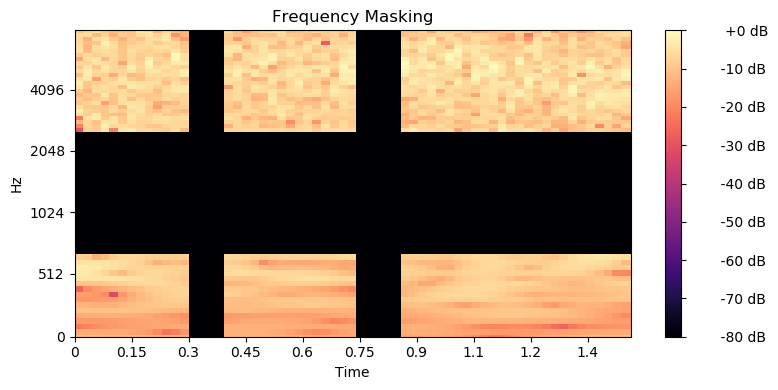

None


In [74]:
# Generate Training Features
train_aug_cq_input = _create_masked_spec(X_train, 30, 10, 20)

97
(97, 70, 63, 1)
(97, 1, 11)
97
(97, 11)


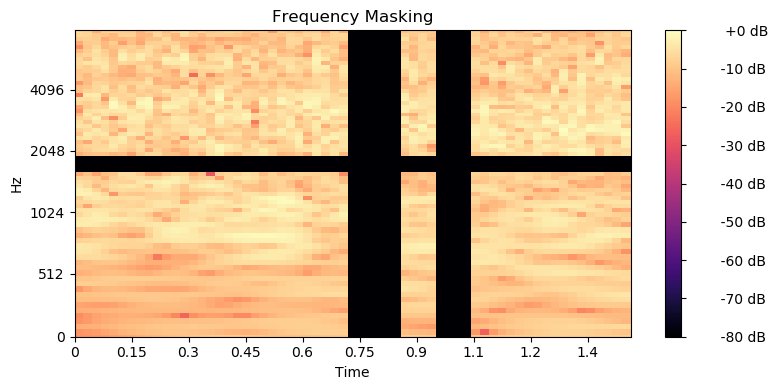

None


In [75]:
# Generate test features
test_cq_input, crepe_test_input = _generate_features(X_test)
test_aug_cq_input = _create_masked_spec(X_test, 30, 10, 20)

In [76]:
print('train input shapes')
print(train_cq_input.shape)
print(train_crepe_input.shape)
print(train_aug_cq_input.shape)
print('test input shapes')
print(test_cq_input.shape)
print(crepe_test_input.shape)
print(test_aug_cq_input.shape)

train input shapes
(652, 70, 63, 1)
(652, 11)
(652, 70, 63, 1)
test input shapes
(97, 70, 63, 1)
(97, 11)
(97, 70, 63, 1)


In [77]:
#train_cq_input = keras.utils.normalize(train_cq_input, axis=-1, order=2)

In [78]:
#Define Single input shape
cq_input_shape = train_cq_input[0].shape
print("CQT Shape",cq_input_shape)
crepe_input_shape = train_crepe_input[0].shape
print("Crepe Input Shape", crepe_input_shape)
aug_cq_shape = train_aug_cq_input[0].shape
print("Aug CQ Input Shape", aug_cq_shape)

CQT Shape (70, 63, 1)
Crepe Input Shape (11,)
Aug CQ Input Shape (70, 63, 1)


In [79]:
# Convert labels to categorical
y_test_labels = to_categorical(y_test)
y_train_labels = to_categorical(y_train)

In [80]:
os.chdir("D:\\aircraft-audio\\local-data")
print(os.getcwd())
from keras import regularizers

D:\aircraft-audio\local-data


### Model Building

#### Model Architecture

In [81]:
def get_model():
    nclass = 2
    initializer1 = keras.initializers.RandomNormal
    initializer2 = keras.initializers.Zeros()
    initializer3 = keras.initializers.glorot_uniform(seed=None)
    initializer4 = keras.initializers.lecun_normal(seed=None)

   
    inp = Input(shape=cq_input_shape)
    img_1 = LeakyReLU(alpha=0.2)(inp)
    img_1 = Conv2D(128, kernel_size=(3,3),       
                   kernel_initializer=initializer4,  kernel_regularizer = regularizers.l2(0.001),         
                   use_bias=True, bias_initializer=initializers.Zeros(),padding="valid")(img_1)
    img_1 = Dropout(0.3)(img_1)
    img_1 = MaxPooling2D(pool_size=(2,2))(img_1)
    
    img_1 = LeakyReLU(alpha=0.2)(img_1)
    img_1 = Conv2D(64, kernel_size=(3,3),       
                   kernel_initializer=initializer4, kernel_regularizer = regularizers.l2(0.001),            
                   use_bias=True, bias_initializer=initializers.Zeros(),padding="valid")(img_1)
    img_1 = LeakyReLU(alpha=0.2)(img_1)
    img_1 = Dropout(0.3)(img_1)
    img_1 = MaxPooling2D(pool_size=(2,2))(img_1)
    
    img_1 = Conv2D(64, kernel_size=(3,3),       
                   kernel_initializer=initializer4,  kernel_regularizer = regularizers.l2(0.001),             
                   use_bias=True, bias_initializer=initializers.Zeros(),padding="valid")(img_1)
    img_1 = LeakyReLU(alpha=0.2)(img_1)
    img_1 = Dropout(0.3)(img_1)
    img_1 = MaxPooling2D(pool_size=(2,2))(img_1)
    
    img_1 = Conv2D(64, kernel_size=(3,3),       
                   kernel_initializer=initializer4,  kernel_regularizer = regularizers.l2(0.001),          
                   use_bias=True, bias_initializer=initializers.Zeros(),padding="valid")(img_1)
    img_1 = LeakyReLU(alpha=0.2)(img_1)
    img_1 = Dropout(0.3)(img_1)
    
    img_1 = Conv2D(64, kernel_size=(3,3),       
                   kernel_initializer=initializer4,  kernel_regularizer = regularizers.l2(0.001),            
                   use_bias=True, bias_initializer=initializers.Zeros(),padding="valid")(img_1)
    img_1 = LeakyReLU(alpha=0.2)(img_1)
    img_1 = Dropout(0.5)(img_1)   
    
    img_1 = MaxPooling2D(pool_size=(2,2))(img_1)
    img_1 = Dropout(0.5)(img_1)
    img_1 = Flatten()(img_1)
    img_1 = Dense(512, kernel_regularizer = regularizers.l2(0.001))(img_1)
    img_1 = Dropout(0.5)(img_1)
    img_1 = Dense(256, kernel_regularizer = regularizers.l2(0.001))(img_1)
    img_1 = Dropout(0.5)(img_1) 

    inp2 = Input(shape=aug_cq_shape)
    img_2 = LeakyReLU(alpha=0.2)(inp2)
    img_2 = Conv2D(128, kernel_size=(3,3),       
                   kernel_initializer=initializer4, kernel_regularizer = regularizers.l2(0.001),           
                   use_bias=True, bias_initializer=initializers.Zeros(),padding="valid")(img_2)
    img_2 = Dropout(0.5)(img_2)
    img_2 = MaxPooling2D(pool_size=(2,2))(img_2)
    
    img_2 = LeakyReLU(alpha=0.2)(img_2)
    img_2 = Conv2D(128, kernel_size=(3,3),       
                   kernel_initializer=initializer4, kernel_regularizer = regularizers.l2(0.001),           
                   use_bias=True, bias_initializer=initializers.Zeros(),padding="valid")(img_2)
    img_2 = LeakyReLU(alpha=0.2)(img_2)
    img_2 = Dropout(0.5)(img_2)
    img_2 = MaxPooling2D(pool_size=(2,2))(img_2)
    
    img_2 = Conv2D(128, kernel_size=(3,3),       
                   kernel_initializer=initializer4, kernel_regularizer = regularizers.l2(0.001),           
                   use_bias=True, bias_initializer=initializers.Zeros(),padding="valid")(img_2)
    img_2 = LeakyReLU(alpha=0.2)(img_2)
    img_2 = Dropout(0.5)(img_2)
    img_2 = MaxPooling2D(pool_size=(2,2))(img_2)
    
    img_2 = Conv2D(128, kernel_size=(3,3),       
                   kernel_initializer=initializer4, kernel_regularizer = regularizers.l2(0.001),           
                   use_bias=True, bias_initializer=initializers.Zeros(),padding="valid")(img_2)
    img_2 = LeakyReLU(alpha=0.2)(img_2)
    img_2 = Dropout(0.5)(img_2)
    
    img_2 = Conv2D(128, kernel_size=(3,3),       
                   kernel_initializer=initializer4, kernel_regularizer = regularizers.l2(0.001),           
                   use_bias=True, bias_initializer=initializers.Zeros(),padding="valid")(img_2)
    img_2 = LeakyReLU(alpha=0.2)(img_2)
    img_2 = Dropout(0.5)(img_2)  
    
    img_2 = MaxPooling2D(pool_size=(2,2))(img_2)
    img_2 = Dropout(0.5)(img_2)
    img_2 = Flatten()(img_2)
    img_2 = Dense(512, kernel_regularizer = regularizers.l2(0.001))(img_2)
    img_2 = Dropout(0.5)(img_2)
    img_2 = Dense(256, kernel_regularizer = regularizers.l2(0.001))(img_2)
    img_2 = Dropout(0.5)(img_2)  
    
    
    crepe_inp = Input(shape=crepe_input_shape)
    crepe_dense = LeakyReLU(alpha=0.2)(crepe_inp)
    
    crepe_dense = Dense(24,  kernel_initializer=initializer4, kernel_regularizer = regularizers.l2(0.001),
                    bias_initializer=initializers.Zeros(),use_bias=True)(crepe_dense)
    crepe_dense = Dropout(0.1)(crepe_dense)   
    
    concat_layer = keras.layers.concatenate([img_1, img_2, crepe_dense])
    concat_dense = LeakyReLU(alpha=0.2)(concat_layer)
    concat_dense = Dense(16, kernel_initializer=initializer4, kernel_regularizer = regularizers.l2(0.001),
                         bias_initializer=initializers.Zeros(),use_bias=True)(concat_dense)
    concat_dense = Dropout(0.4)(concat_dense)
    concat_dense = Dense(12, kernel_regularizer = regularizers.l2(0.001))(concat_dense)
    
    output_layer = Dense(2,activation=activations.sigmoid)(concat_dense)
    model = models.Model(inputs=[inp, inp2, crepe_inp], outputs=[output_layer])
    opt = optimizers.Adam(lr=0.00003, beta_1=0.9, beta_2=0.999, epsilon=1e-5, decay=0.00, amsgrad=True)
    model.compile(optimizer=opt, loss=losses.binary_crossentropy, metrics=['acc'])
    model.summary()
    from keras.utils import plot_model
    plot_model(model, to_file='model.png')
    
    return model

In [82]:
# If wanted, add class weighting
total_len = len(y_train)
class_weight = {0: total_len/len([x for x in y_train==0 if x]),
                1: total_len/len([x for x in y_train==1 if x])}

In [83]:
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=5, min_lr=0.000001)


In [84]:
cq_crepe_model = get_model()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 70, 63, 1)    0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            (None, 70, 63, 1)    0                                            
__________________________________________________________________________________________________
leaky_re_lu_15 (LeakyReLU)      (None, 70, 63, 1)    0           input_4[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_21 (LeakyReLU)      (None, 70, 63, 1)    0           input_5[0][0]                    
__________________________________________________________________________________________________
conv2d_11 

In [85]:
mcp_save = ModelCheckpoint('best_airplane_landing_12_2.hdf5', save_best_only=True, monitor='val_acc', mode='max')


In [145]:

history = cq_crepe_model.fit([train_cq_input, train_aug_cq_input, train_crepe_input],[to_categorical(y_train)], 
                         epochs=200,verbose=1, batch_size=4,
                         validation_data=([test_cq_input, test_aug_cq_input,crepe_test_input], to_categorical(y_test)), 
                         callbacks=[reduce_lr], shuffle=True,
                         class_weight=class_weight, 
                         sample_weight=None)


Train on 652 samples, validate on 97 samples
Epoch 1/200
652/652 [==============================] - 5s 7ms/step - loss: 5.9488 - acc: 0.6089 - val_loss: 3.1585 - val_acc: 0.7577
Epoch 2/200
652/652 [==============================] - 5s 7ms/step - loss: 6.6194 - acc: 0.5560 - val_loss: 3.1594 - val_acc: 0.7526
Epoch 3/200
652/652 [==============================] - 5s 7ms/step - loss: 6.3100 - acc: 0.5468 - val_loss: 3.1602 - val_acc: 0.7526
Epoch 4/200
652/652 [==============================] - 5s 7ms/step - loss: 5.9644 - acc: 0.5537 - val_loss: 3.1592 - val_acc: 0.7526
Epoch 5/200
652/652 [==============================] - 5s 7ms/step - loss: 6.4299 - acc: 0.5713 - val_loss: 3.1607 - val_acc: 0.7526
Epoch 6/200
652/652 [==============================] - 5s 7ms/step - loss: 5.8370 - acc: 0.5821 - val_loss: 3.1605 - val_acc: 0.7526
Epoch 7/200
652/652 [==============================] - 5s 7ms/step - loss: 6.1416 - acc: 0.5637 - val_loss: 3.1610 - val_acc: 0.7474
Epoch 8/200
652/652 [===

Epoch 62/200
652/652 [==============================] - 5s 7ms/step - loss: 5.8784 - acc: 0.5828 - val_loss: 3.1573 - val_acc: 0.7474
Epoch 63/200
652/652 [==============================] - 5s 7ms/step - loss: 5.8942 - acc: 0.5752 - val_loss: 3.1583 - val_acc: 0.7474
Epoch 64/200
652/652 [==============================] - 5s 7ms/step - loss: 6.0531 - acc: 0.5706 - val_loss: 3.1574 - val_acc: 0.7474
Epoch 65/200
652/652 [==============================] - 5s 7ms/step - loss: 5.6945 - acc: 0.5683 - val_loss: 3.1557 - val_acc: 0.7423
Epoch 66/200
652/652 [==============================] - 5s 7ms/step - loss: 5.7662 - acc: 0.5882 - val_loss: 3.1569 - val_acc: 0.7474
Epoch 67/200
652/652 [==============================] - 5s 7ms/step - loss: 5.9667 - acc: 0.5890 - val_loss: 3.1564 - val_acc: 0.7474
Epoch 68/200
652/652 [==============================] - 5s 7ms/step - loss: 5.9198 - acc: 0.5767 - val_loss: 3.1559 - val_acc: 0.7474
Epoch 69/200
652/652 [==============================] - 5s 7ms

652/652 [==============================] - 5s 7ms/step - loss: 5.4937 - acc: 0.5989 - val_loss: 3.1577 - val_acc: 0.7474
Epoch 123/200
652/652 [==============================] - 5s 7ms/step - loss: 5.7798 - acc: 0.5851 - val_loss: 3.1581 - val_acc: 0.7474
Epoch 124/200
652/652 [==============================] - 5s 7ms/step - loss: 6.5343 - acc: 0.5437 - val_loss: 3.1581 - val_acc: 0.7474
Epoch 125/200
652/652 [==============================] - 5s 7ms/step - loss: 5.9297 - acc: 0.5706 - val_loss: 3.1562 - val_acc: 0.7474
Epoch 126/200
652/652 [==============================] - 5s 7ms/step - loss: 6.0202 - acc: 0.6020 - val_loss: 3.1553 - val_acc: 0.7526
Epoch 127/200
652/652 [==============================] - 5s 7ms/step - loss: 5.8041 - acc: 0.5736 - val_loss: 3.1540 - val_acc: 0.7526
Epoch 128/200
652/652 [==============================] - 5s 7ms/step - loss: 5.7764 - acc: 0.5790 - val_loss: 3.1536 - val_acc: 0.7526
Epoch 129/200
652/652 [==============================] - 5s 7ms/step 

Epoch 183/200
652/652 [==============================] - 5s 7ms/step - loss: 5.8588 - acc: 0.5874 - val_loss: 3.1488 - val_acc: 0.7577
Epoch 184/200
652/652 [==============================] - 5s 7ms/step - loss: 5.6787 - acc: 0.5721 - val_loss: 3.1499 - val_acc: 0.7577
Epoch 185/200
652/652 [==============================] - 5s 7ms/step - loss: 5.5507 - acc: 0.6043 - val_loss: 3.1498 - val_acc: 0.7577
Epoch 186/200
652/652 [==============================] - 5s 7ms/step - loss: 5.7814 - acc: 0.5805 - val_loss: 3.1490 - val_acc: 0.7577
Epoch 187/200
652/652 [==============================] - 5s 7ms/step - loss: 6.1323 - acc: 0.5468 - val_loss: 3.1489 - val_acc: 0.7577
Epoch 188/200
652/652 [==============================] - 5s 7ms/step - loss: 5.7506 - acc: 0.5759 - val_loss: 3.1494 - val_acc: 0.7577
Epoch 189/200
652/652 [==============================] - 5s 7ms/step - loss: 6.2353 - acc: 0.5552 - val_loss: 3.1498 - val_acc: 0.7577
Epoch 190/200
652/652 [==============================] 

In [146]:
# Save Model
cq_crepe_model.save('_Model_Airline_12_2.h5')

#### Graph the results

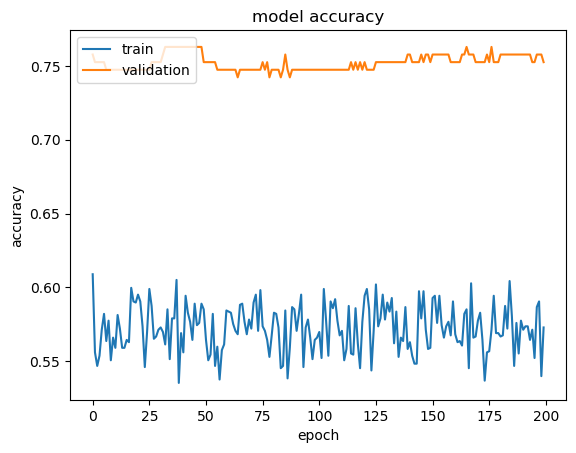

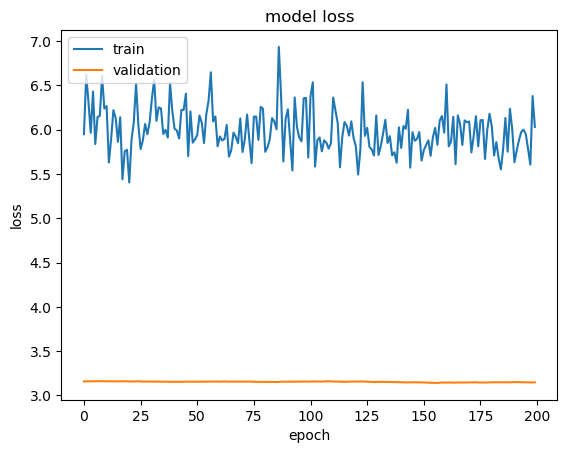

In [147]:
import matplotlib.pyplot as plt
#Accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [148]:
cq_crepe_model.evaluate([test_cq_input, test_aug_cq_input, crepe_test_input],y_test_labels)

97/97 [==============================] - 0s 825us/step


[3.148704172409687, 0.7525773195876289]

#### Confusion Matrix

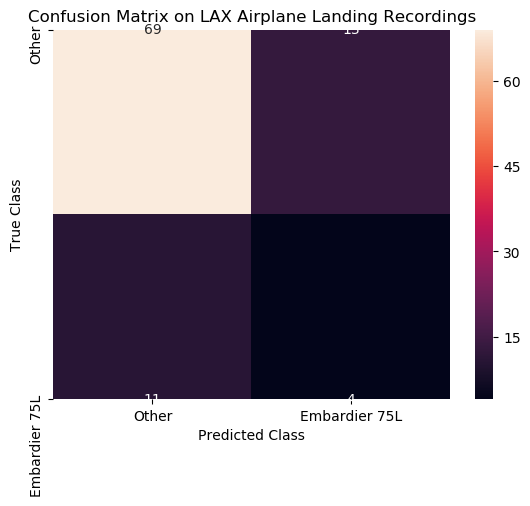

             precision    recall  f1-score   support

        0.0       0.86      0.84      0.85        82
        1.0       0.24      0.27      0.25        15

avg / total       0.77      0.75      0.76        97



In [149]:
plt.style.use('default')
plt.margins(1)
import importlib
import matplotlib
importlib.reload(matplotlib); importlib.reload(plt); importlib.reload(sns)

                    
preds =np.argmax(cq_crepe_model.predict([test_cq_input, test_aug_cq_input,crepe_test_input]), axis=1)
cm = confusion_matrix(y_test.tolist(), preds.tolist())

ax = sns.heatmap(cm, annot=True, fmt='g')
ax.set_title('Confusion Matrix on LAX Airplane Landing Recordings')
ax.xaxis.set_ticklabels(['Other', 'Embardier 75L'])
ax.yaxis.set_ticklabels(['Other', 'Embardier 75L'])
ax.set(xlabel='Predicted Class', ylabel='True Class')
plt.show()
print(classification_report(y_test.tolist(), preds.tolist()))

In [150]:
cm

array([[69, 13],
       [11,  4]], dtype=int64)

# The End